# Figure 4: Contour map and percent traversed analysis of CFS

This notebook analyzes the 63x CFS videos. It generates a "contour map" and calculates the fraction of particles that have traversed a distance of 25 micrometers away from the activation region. It generates figures for several intermediate steps, culminating in Figure 4. 

Updated 2015-12-16

## Overview

1. Import packages; load data and metadata.
2. Define functions.
3. Run the analysis on three videos.
4. Draw the final figure.


## Step 1: Import packages; load data and metadata.

All of the dependencies are given in the `environment.yml` file in this repository.

In [1]:
%matplotlib notebook

from itertools import cycle
from collections import OrderedDict

import yaml
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pims

import skimage
from skimage.filters import gaussian_filter

import photoactivation as pa  # importing from photoactivation.py in the working directory

C:\Users\Benjamin\Miniconda\envs\pa\lib\site-packages\IPython\kernel\__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)
C:\Users\Benjamin\Miniconda\envs\pa\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# Use Bob's plot style preferences
# mpl.style.use('https://tiny.cc/leheny-style/raw')

In [3]:
calibrations = yaml.load(open('calibrations.yml'))

In [4]:
#on Mac, use this instead '/Users/benjaminschuster/Documents/photoactivation/data/' 
filepath = ['C:/Users/Benjamin/Desktop/PANDA videos/20140521 CFS-20140520-4 JCK20140519 PGLA-PEG 10fold 63x 1.57s 10iters maxAU 6.lsm',
            'C:/Users/Benjamin/Desktop/PANDA videos/20140522 CFS-20140520-1 JCK20140519 PGLA-PEG 10fold 63x 1.57s 10iters maxAU 2.lsm',
            'C:/Users/Benjamin/Desktop/PANDA videos/20140521 CFS-20140520-2 JCK20140519 PGLA-PEG 10fold 63x 1.57s 10iters maxAU 3.lsm']
objective = '63X'
exposure_time = 1.570 # s
first_illuminated_frame = 5
mpp = calibrations[objective]

In [5]:
w = 30 # half-width of activation region, for the CFS 63x videos
dym = 25 # distance in microns past the activation region for which I want to know % of particles traversed
dyp = int(round(dym/mpp)) # convert dym to pixels and round

## Step 2: Define functions

In [6]:
# A pims.pipeline is a function that only gets evaluated at the last moment.

@pims.pipeline
def grayscale(img):
    return np.sum(img, 0)

In [7]:
def makeContourMap(v,frms,threshfrac):
    numf = len(frms)
    for i in range(0,numf):
        I = skimage.filters.gaussian_filter(np.float64(v[np.uint16(frms[i])]), sigma = 3)
        Ith = I > threshfrac*np.max(I) # is this OK?
        if i == 0:
            Z = (numf-i)*Ith;
        else:
            Z = Z + (numf-i)*(Ith>np.uint8(Z>0))
    
    plt.figure()      
    plt.imshow(Z)        
    return Z

In [8]:
def calcPercentTraversed(v,w,dyp):
    sumv = [np.sum(v[i].astype(np.float64)) for i in range(len(v))]
    
    y = len(v[1])
    edge1 = int(y/2-dyp-w)
    edge2 = int(y/2+dyp+w)
    s = list(range(0,edge1)) + list(range(edge2,y))   
    sumvfar = [np.sum(v[i][s,:].astype(np.float64)) for i in range(len(v))]

    ptraversed = 100*(sumvfar-np.min(sumvfar[15:]))/sumv
#    ptraversed = (sumvfar[15:]-np.min(sumvfar[15:]))/sumv[15:]
#    ptraversed = (sumvfar[15:]-(sumvfar[50]))/sumv[15:]

    plt.figure()
    plt.subplot(1, 3, 1)
    plt.plot(sumv)
    plt.subplot(1, 3, 2)
    plt.plot(sumvfar)
    plt.subplot(1, 3, 3)
    plt.plot(ptraversed)
    
    return sumv, sumvfar, ptraversed

## Step 3: Run the analysis on three videos

In [16]:
#frms = first_illuminated_frame + np.array([25, 50, 100, 175, 300, 500, 700, 990]) #frames to use for contour map
#frames to use for contour map - choose convenient times (in minutes) and convert to frames
frms = first_illuminated_frame + np.round(np.array([0.5, 2, 4, 6, 8, 10])*60/exposure_time) 
threshfrac = 0.3

C:\Users\Benjamin\Miniconda\envs\pa\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


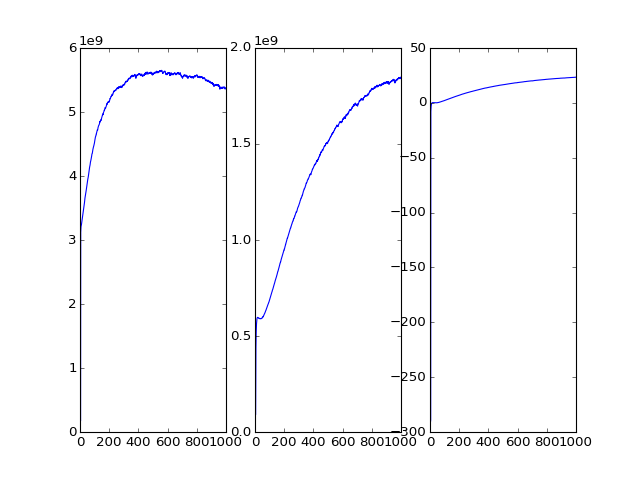

<IPython.core.display.Javascript object>


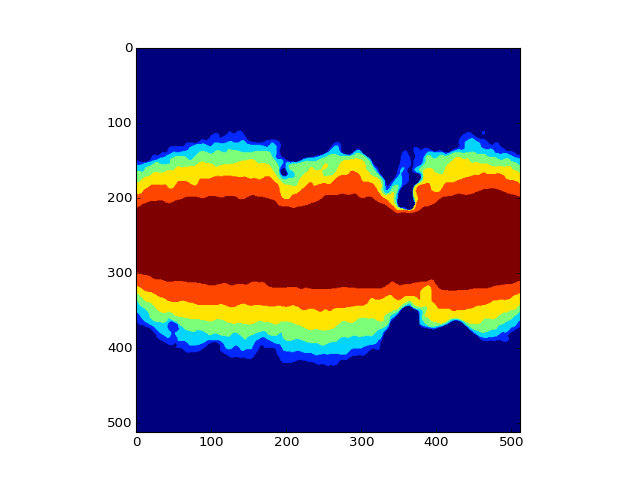

<IPython.core.display.Javascript object>


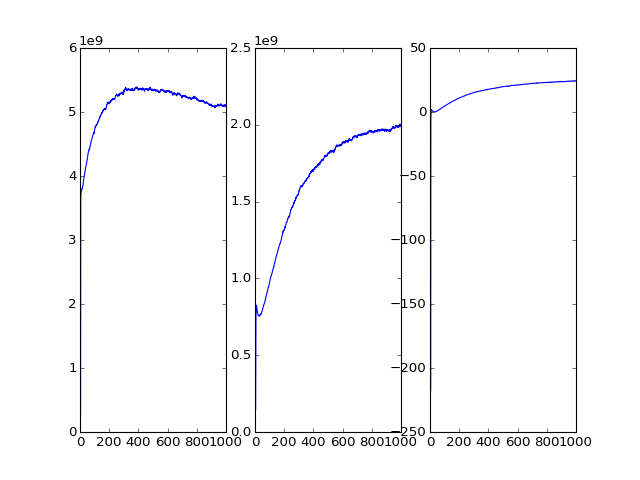

<IPython.core.display.Javascript object>


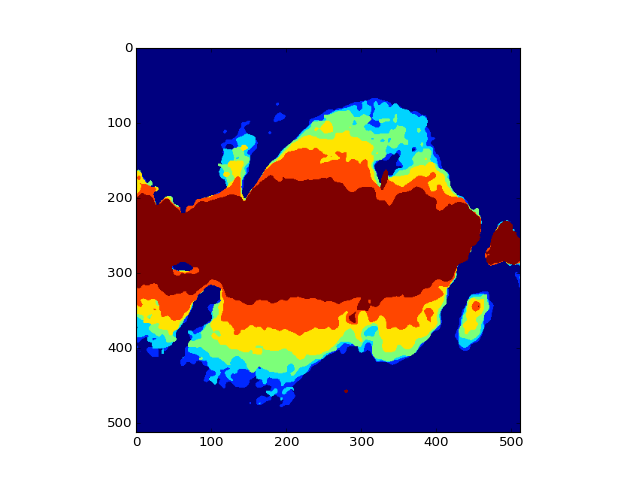

<IPython.core.display.Javascript object>


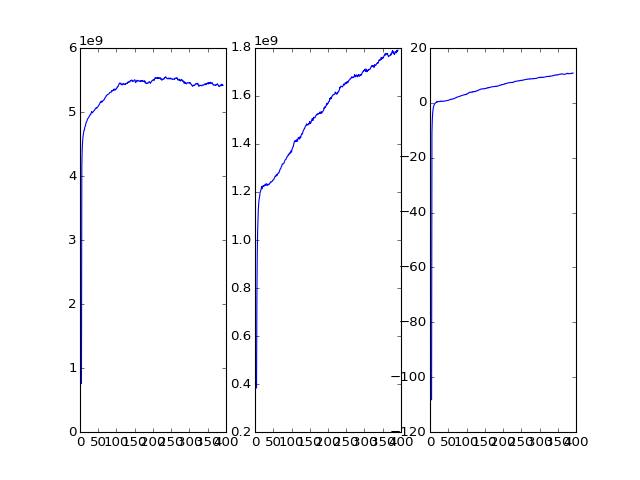

<IPython.core.display.Javascript object>


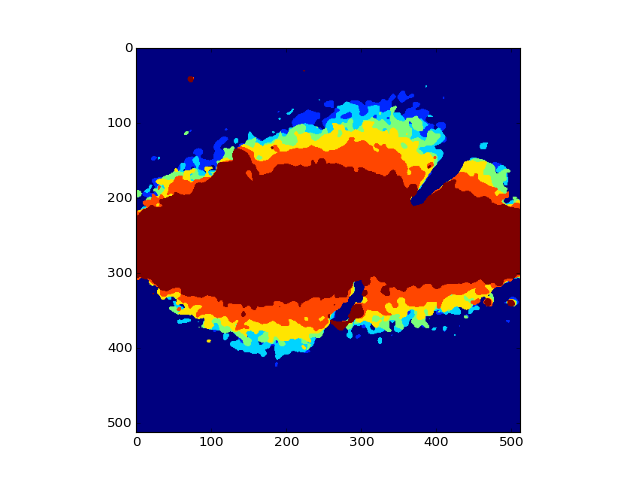

In [19]:
P = np.zeros((392,3)) # to store the percent traversed data (assuming 1000 frames in video )
M = np.zeros((512,512,3)) # to store the contour map (assuming 512 by 512 video)
L = np.zeros((512,512,3)) # to store last frame in video
for i in range(3):
    v = grayscale(pims.open(filepath[i]))
    sumv, sumvfar, ptraversed = calcPercentTraversed(v,w,dyp)
    P[:,i] = ptraversed[:392]
    Z = makeContourMap(v,frms,threshfrac)
    M[:,:,i] = Z
    L[:,:,i]= v[392]

## Step 4: Draw the final figure

C:\Users\Benjamin\Miniconda\envs\pa\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


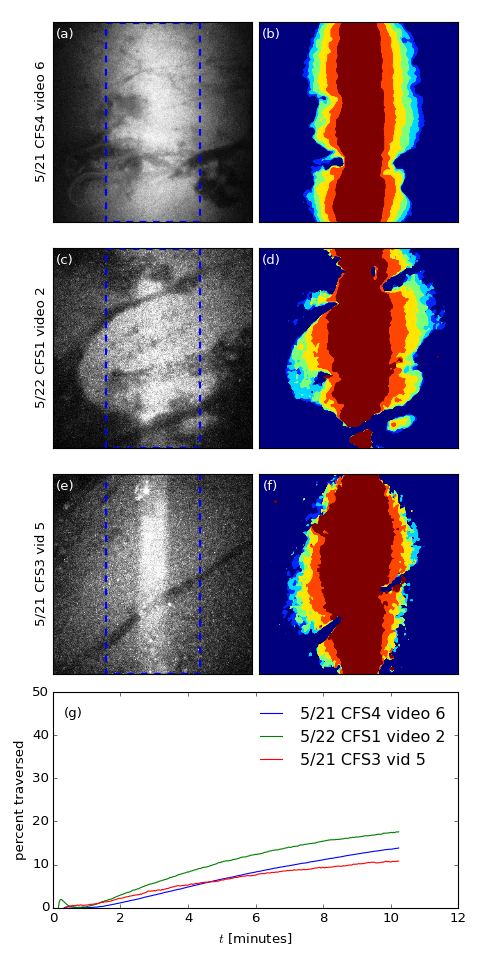

In [21]:
plt.figure(figsize=(6, 12))

# Construct a grid of subplots.
grid = mpl.gridspec.GridSpec(4, 2, width_ratios=[1, 1])
image_axes = list(map(plt.subplot, [grid[i, 0] for i in range(4)]))
contour_axes = list(map(plt.subplot, [grid[i, 1] for i in range(4)]))
plot_ax = plt.subplot(grid[-1, :])

# Configure axes labels / ticks.
[ax.set(xticks=[], yticks=[]) for ax in image_axes]
[ax.set(xticks=[], yticks=[]) for ax in contour_axes]

# Draw in the frames of video.
vid_nos = range(0,3)
label = ['5/21 CFS4 video 6','5/22 CFS1 video 2','5/21 CFS3 vid 5']
for ax, vid_no in zip(image_axes, vid_nos):
    image = L[:,:,vid_no]
    # flip diagonally
    image = image.T
    ax.imshow(image, cmap = cm.Greys_r)
    ylab = label[vid_no] 
    #ylab = 'Patient ' + str(vid_no + 1)
    image_axes[vid_no].set(ylabel=ylab)

# Draw in the contour maps
vid_nos = range(0,3)
for ax, vid_no in zip(contour_axes, vid_nos):
    image = M[:,:,vid_no]
    # flip diagonally
    image = image.T
    ax.imshow(image)
    
# Outline 25 um past the activation region.
rectangle1 = mpl.patches.Rectangle((512//2 - dyp - w, 0), 2*(w+dyp), 511,
                                  facecolor='none', edgecolor='blue', linewidth=2, linestyle='dashed',
                                  transform=image_axes[0].transData)
rectangle2 = mpl.patches.Rectangle((512//2 - dyp - w, 0), 2*(w+dyp), 511,
                                  facecolor='none', edgecolor='blue', linewidth=2, linestyle='dashed',
                                  transform=image_axes[1].transData)
rectangle3 = mpl.patches.Rectangle((512//2 - dyp - w, 0), 2*(w+dyp), 511,
                                  facecolor='none', edgecolor='blue', linewidth=2, linestyle='dashed',
                                  transform=image_axes[2].transData)
image_axes[0].add_patch(rectangle1)
image_axes[1].add_patch(rectangle2)
image_axes[2].add_patch(rectangle3)
       
# Draw in the percent traversed vs. t data.
lag_times = np.arange(392)*exposure_time/60
plot_ax.plot(lag_times,P)
plot_ax.set(ylim=(0, 50))
plot_ax.set(yticks=[0, 10, 20, 30, 40, 50])
plot_ax.set(xlabel=r'$t$ [minutes]', ylabel=r'percent traversed')
    
# Label (a), (b), (c).
image_axes[0].text(0.06, 0.94, '(a)', ha='center', va='center', transform=image_axes[0].transAxes, color='white')
contour_axes[0].text(0.06, 0.94, '(b)', ha='center', va='center', transform=contour_axes[0].transAxes, color='white')
image_axes[1].text(0.06, 0.94, '(c)', ha='center', va='center', transform=image_axes[1].transAxes, color='white')
contour_axes[1].text(0.06, 0.94, '(d)', ha='center', va='center', transform=contour_axes[1].transAxes, color='white')
image_axes[2].text(0.06, 0.94, '(e)', ha='center', va='center', transform=image_axes[2].transAxes, color='white')
contour_axes[2].text(0.06, 0.94, '(f)', ha='center', va='center', transform=contour_axes[2].transAxes, color='white')
plot_ax.text(0.05, 0.9, '(g)', ha='center', va='center', transform=plot_ax.transAxes)

plot_ax.legend(['5/21 CFS4 video 6','5/22 CFS1 video 2','5/21 CFS3 vid 5']).draw_frame(False) 

# Tweak subplot spacing.
# plot_ax.figure.set_size_inches(14.5, 7)
grid.tight_layout(plot_ax.figure, h_pad=0.3, w_pad=0.5)

To do:
- Get the t axis exactly correct (don't forget about bleach time).
- % traversed at short times looks odd
- Data points rather than line for % traversed?
- Lines rather than rectangle to denote 25 um away
- Scale bar
- Contour map on left rather than right?
- Distant bright spot in second video